# Imports & Notebook Setup

We will import the necessary packages utilized for modeling/evaluation in this notebook. We also make sure that our viualizations are exported to results/figures/modeling & evalutation/ directory, and metrics are exported to results/metrics directory:

In [1]:
import os
import sys 
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
from sklearn.preprocessing import LabelEncoder

# Allow imports from ../src directory
sys.path.append(os.path.abspath(".."))
from src.train_models import (
    build_logistic_regression_model,
    build_random_forest_model,
    build_xgboost
)
from src.preprocessing import (
    train_val_test_split,
    build_preprocessor
)
FIG_DIR = "../results/figures/modeling & evaluation/"
METRICS_DIR = "../results/metrics/"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)
_plt_original_show = plt.show
_plt_fig_counter = {"count": 0}
def _save_and_show(*args, **kwargs) -> None:
    _plt_fig_counter["count"] += 1
    filename = os.path.join(FIG_DIR, f"figure_{_plt_fig_counter['count']:03d}.png")
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    _plt_original_show(*args, **kwargs)
plt.show = _save_and_show

Compilation complete
Compilation complete


- `pandas`: data wrangling and CSV loading
- `numpy`: array and numerical operations
- `matplotlib` & `seaborn`: visualizations and plots
- `os`, `sys`, `pathlib`: directory management and custom imports
- `sklearn`: train/test splitting, evaluation metrics and label encoding. 
-  `src.preprocessing`: utilities for feature/target separation, stratified splitting, and building preprocessing pipelines.
-  `src.train_models`: Logistic Regression, Random Forest and XGBoost.

# Feature and Target Seperation

Load `ais_data_model_ready` and seperate features (X) and target (y)

In [2]:
model_df = pd.read_csv("../data/ais_data_model_ready.csv")
TARGET_COL = "navigationalstatus"
X = model_df.drop(columns=[TARGET_COL])
y = model_df[TARGET_COL]
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"List of features names: {X.columns.tolist()}")
print(f"Target variable: {y.name}")

Number of features: 7
Number of samples: 325470
List of features names: ['sog', 'cog', 'heading', 'width', 'length', 'draught', 'shiptype']
Target variable: navigationalstatus


# Train / Validation / Test Split

Two-stage stratified split to preserve class distribution across all splits:

1. Stage 1 (80/20): 80% -> Train+Val, 20% -> Test
2. Stage 2 (80/20 of the 80%): 80% of 80% -> Train (64%), 20% of 80% -> Val (16%)

Final Distribution
- Training: 64%, Validation: 16%, Test: 20%

Function Parameters
- `test_size`: 20% reserved for final evaluation (untouched during development)
- `val_size`: 16% for hyperparameter tuning
- `random_state`: Ensures reproducibility
- Stratified: Preserves imbalanced class distribution across all splits

The function returns 6 variables: `X_train, X_val, X_test, y_train, y_val, y_test`

In [3]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X,
    y,
    test_size=0.2,  # 20% reserved for final evaluation (untouched during development)
    val_size=0.16,  # 16% for hyperparameter tuning
    random_state=42
)
print("Train/val/test split complete!")

Train/val/test split complete!


In [4]:
# Print split information
print(f"Total samples: {len(X)}")
print(f"\nTrain set:")
print(f"  Shape: {X_train.shape}")
print(f"  Percentage: {len(X_train)/len(X)*100:.1f}%")
print(f"\nValidation set:")
print(f"  Shape: {X_val.shape}")
print(f"  Percentage: {len(X_val)/len(X)*100:.1f}%")
print(f"\nTest set:")
print(f"  Shape: {X_test.shape}")
print(f"  Percentage: {len(X_test)/len(X)*100:.1f}%")

Total samples: 325470

Train set:
  Shape: (208300, 7)
  Percentage: 64.0%

Validation set:
  Shape: (52075, 7)
  Percentage: 16.0%

Test set:
  Shape: (65095, 7)
  Percentage: 20.0%


In [5]:
# Check set class distribution
print("Train set class distribution:")
print(y_train.value_counts(normalize=True).sort_index())

Train set class distribution:
navigationalstatus
At anchor                                                0.001512
Constrained by her draught                               0.037686
Engaged in fishing                                       0.015089
Moored                                                   0.010355
Power-driven vessel pushing ahead or towing alongside    0.000725
Power-driven vessel towing astern                        0.000759
Reserved for future amendment [HSC]                      0.005372
Restricted maneuverability                               0.004983
Under way sailing                                        0.004057
Under way using engine                                   0.919462
Name: proportion, dtype: float64


In [6]:
# Check validation set class distribution
print("Validation set class distribution:")
print(y_val.value_counts(normalize=True).sort_index())

Validation set class distribution:
navigationalstatus
At anchor                                                0.001517
Constrained by her draught                               0.037696
Engaged in fishing                                       0.015094
Moored                                                   0.010350
Power-driven vessel pushing ahead or towing alongside    0.000730
Power-driven vessel towing astern                        0.000749
Reserved for future amendment [HSC]                      0.005358
Restricted maneuverability                               0.004974
Under way sailing                                        0.004071
Under way using engine                                   0.919462
Name: proportion, dtype: float64


In [7]:
# Check test set class distribution
print("Test set class distribution:")
print(y_test.value_counts(normalize=True).sort_index())

Test set class distribution:
navigationalstatus
At anchor                                                0.001505
Constrained by her draught                               0.037683
Engaged in fishing                                       0.015086
Moored                                                   0.010369
Power-driven vessel pushing ahead or towing alongside    0.000722
Power-driven vessel towing astern                        0.000753
Reserved for future amendment [HSC]                      0.005377
Restricted maneuverability                               0.004993
Under way sailing                                        0.004056
Under way using engine                                   0.919456
Name: proportion, dtype: float64


# Define Evaluation Helper

Create a function that will provide us a standard to score each model.

In [8]:
def evaluate_classifier(model, X, y, model_name, split_name, label_encoder=None):
    """
    Evaluate a fitted classifier and return a dictionary of metrics.
    
    Args:
        model: A fitted sklearn-style classifier with .predict() method
        X: Feature matrix (NumPy array or pandas DataFrame)
        y: True labels
        model_name: String identifier for the model (e.g., "Logistic Regression")
        split_name: String identifier for the data split (e.g., "val" or "test")
        label_encoder: Optional LabelEncoder to decode predictions (required for XGBoost)
    
    Returns:
        dict: Dictionary containing all computed metrics, predictions, and metadata
    """
    
    # Get predictions
    y_pred = model.predict(X)
    
    # Decode predictions if label_encoder provided (for XGBoost)
    if label_encoder is not None:
        y_pred = label_encoder.inverse_transform(y_pred)
    
    # Compute metrics
    accuracy = accuracy_score(y, y_pred)
    macro_f1 = f1_score(y, y_pred, average="macro")
    weighted_f1 = f1_score(y, y_pred, average="weighted")
    precision_macro = precision_score(y, y_pred, average="macro")
    recall_macro = recall_score(y, y_pred, average="macro")
    
    # Confusion matrix and classification report
    cm = confusion_matrix(y, y_pred)
    cr = classification_report(y, y_pred)
    
    # Print concise summary
    print(
        f"{model_name} [{split_name}] | "
        f"Accuracy: {accuracy:.3f} | "
        f"Macro-F1: {macro_f1:.3f} | "
        f"Weighted-F1: {weighted_f1:.3f} | "
        f"Precision (Macro): {precision_macro:.3f} | "
        f"Recall (Macro): {recall_macro:.3f}"
    )
    
    # Return results dictionary
    return {
        "model_name": model_name,
        "split": split_name,
        "accuracy": accuracy,
        "macro_f1": macro_f1,
        "weighted_f1": weighted_f1,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "confusion_matrix": cm,
        "classification_report": cr,
        "y_true": y,
        "y_pred": y_pred
    }

print("Evaluation function instantiated.")

Evaluation function instantiated.


# Build and Train Models

From `train_models.py`, we are going to use 3 models:
- Logistic Regression:
    - Used as a simple linear baseline that is interpretable and effective for many classification problems.
- Random Forest:
    - Chosen as a robust nonlinear baseline capable of capturing complex patterns and interactions in the data.
- XGBoost:
    - Included as a strong performance baseline due to its efficiency and state-of-the-art results in many classification tasks.


In [9]:
# Instantiate preprocessor
preprocessor = build_preprocessor()

# Fit preprocessor on training data. Transform splits.
print("Fitting preprocessor on training data...")
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_test_preprocessed = preprocessor.transform(X_test)
print(f"Training data shape after preprocessing: {X_train_preprocessed.shape}")
print(f"Validation data shape after preprocessing: {X_val_preprocessed.shape}")
print(f"Test data shape after preprocessing: {X_test_preprocessed.shape}")
print("Preprocessing complete.\n")

# Build Models
print("Building models...")
logistic_regression_model = build_logistic_regression_model()
random_forest_model = build_random_forest_model()
xgboost_model = build_xgboost()
print("The models are built.\n")

# Train Models
print("Training Logistic Regression...")
logistic_regression_model.fit(X_train_preprocessed, y_train)
print("Logistic Regression training complete.\n")

print("Training Random Forest...")
random_forest_model.fit(X_train_preprocessed, y_train)
print("Random Forest training complete.\n")

# Encode target labels
print("Prepping target labels for XGBoost...")
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)
print("Target labels encoded.\n")

print("Training XGBoost...")
xgboost_model.fit(X_train_preprocessed, y_train_encoded)
print("XGBoost training complete.\n")
print("\nModel training complete. Awaiting comparison on validation set.")

Fitting preprocessor on training data...
Training data shape after preprocessing: (208300, 23)
Validation data shape after preprocessing: (52075, 23)
Test data shape after preprocessing: (65095, 23)
Preprocessing complete.

Building models...
The models are built.

Training Logistic Regression...


/opt/anaconda3/envs/maritime-ais-ml/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression training complete.

Training Random Forest...
Random Forest training complete.

Prepping target labels for XGBoost...
Target labels encoded.

Training XGBoost...
XGBoost training complete.


Model training complete. Awaiting comparison on validation set.


# Compare Models on Validation Set 

In [10]:
print("MODEL COMPARISON ON VALIDATION SET\n")

# Evaluate Logistic Regression on validation set
lr_val_results = evaluate_classifier(
    logistic_regression_model,
    X_val_preprocessed,
    y_val,
    "Logistic Regression",
    "val"
)

# Evaluate Random Forest on validation set
rf_val_results = evaluate_classifier(
    random_forest_model,
    X_val_preprocessed,
    y_val,
    "Random Forest",
    "val"
)

# Evaluate XGBoost (with label encoder) on validation set
xgb_val_results = evaluate_classifier(
    xgboost_model,
    X_val_preprocessed,
    y_val,
    "XGBoost",
    "val",
    label_encoder=label_encoder
)

print("\nVALIDATION SET COMPARISON SUMMARY\n")

# Create a comparison DataFrame
comparison_data = {
    "Model": [
        lr_val_results["model_name"],
        rf_val_results["model_name"],
        xgb_val_results["model_name"]
    ],
    "Accuracy": [
        lr_val_results["accuracy"],
        rf_val_results["accuracy"],
        xgb_val_results["accuracy"]
    ],
    "Macro-F1": [
        lr_val_results["macro_f1"],
        rf_val_results["macro_f1"],
        xgb_val_results["macro_f1"]
    ],
    "Weighted-F1": [
        lr_val_results["weighted_f1"],
        rf_val_results["weighted_f1"],
        xgb_val_results["weighted_f1"]
    ],
    "Precision (Macro)": [
        lr_val_results["precision_macro"],
        rf_val_results["precision_macro"],
        xgb_val_results["precision_macro"]
    ],
    "Recall (Macro)": [
        lr_val_results["recall_macro"],
        rf_val_results["recall_macro"],
        xgb_val_results["recall_macro"]
    ]
}
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))
print()

MODEL COMPARISON ON VALIDATION SET

Logistic Regression [val] | Accuracy: 0.717 | Macro-F1: 0.373 | Weighted-F1: 0.797 | Precision (Macro): 0.303 | Recall (Macro): 0.784
Random Forest [val] | Accuracy: 0.986 | Macro-F1: 0.875 | Weighted-F1: 0.985 | Precision (Macro): 0.915 | Recall (Macro): 0.844
XGBoost [val] | Accuracy: 0.978 | Macro-F1: 0.834 | Weighted-F1: 0.978 | Precision (Macro): 0.886 | Recall (Macro): 0.800

VALIDATION SET COMPARISON SUMMARY

              Model  Accuracy  Macro-F1  Weighted-F1  Precision (Macro)  Recall (Macro)
Logistic Regression  0.717216  0.373483     0.797138           0.303367        0.783701
      Random Forest  0.985578  0.875066     0.985190           0.914565        0.844384
            XGBoost  0.978435  0.834280     0.977790           0.886171        0.799931



**MODEL EVALUATION ON VALIDATION SET**

| Model                 | Accuracy | Macro-F1 | Weighted-F1 | Precision (Macro) | Recall (Macro) |
|-----------------------|----------|----------|-------------|-------------------|---------------|
| Logistic Regression   | 0.694    | 0.343    | 0.778       | 0.276             | 0.757         |
| Random Forest         | 0.985    | 0.881    | 0.984       | 0.934             | 0.845         |
| XGBoost               | 0.978    | 0.839    | 0.978       | 0.896             | 0.803         |


Logistic Regression demonstrates noticeably weaker performance on the validation set, particularly in macro-F1 and macro-precision, reflecting limited ability to handle minority classes. 

Random Forest stands out as the top performer by a considerable margin; it achieves the highest accuracy and robust scores across all metrics, suggesting strong generalization. 

XGBoost also performs well - close to Random Forest - though it trails slightly in all reported metrics, highlighting it as a competitive but marginally less effective alternative on this dataset.




# Final Evaluation on Test Set 

In [11]:
print("MODEL EVALUATION ON TEST SET\n")

# Evaluate Logistic Regression on test set
lr_test_results = evaluate_classifier(
    logistic_regression_model,
    X_test_preprocessed,
    y_test,
    "Logistic Regression",
    "test"
)

# Evaluate Random Forest on test set
rf_test_results = evaluate_classifier(
    random_forest_model,
    X_test_preprocessed,
    y_test,
    "Random Forest",
    "test"
)

# Evaluate XGBoost on test set (with label encoder)
xgb_test_results = evaluate_classifier(
    xgboost_model,
    X_test_preprocessed,
    y_test,
    "XGBoost",
    "test",
    label_encoder=label_encoder
)

print("\nTEST SET COMPARISON SUMMARY\n")

# Create a comparison DataFrame for test set
test_comparison_data = {
    "Model": [
        lr_test_results["model_name"],
        rf_test_results["model_name"],
        xgb_test_results["model_name"]
    ],
    "Accuracy": [
        lr_test_results["accuracy"],
        rf_test_results["accuracy"],
        xgb_test_results["accuracy"]
    ],
    "Macro-F1": [
        lr_test_results["macro_f1"],
        rf_test_results["macro_f1"],
        xgb_test_results["macro_f1"]
    ],
    "Weighted-F1": [
        lr_test_results["weighted_f1"],
        rf_test_results["weighted_f1"],
        xgb_test_results["weighted_f1"]
    ],
    "Precision (Macro)": [
        lr_test_results["precision_macro"],
        rf_test_results["precision_macro"],
        xgb_test_results["precision_macro"]
    ],
    "Recall (Macro)": [
        lr_test_results["recall_macro"],
        rf_test_results["recall_macro"],
        xgb_test_results["recall_macro"]
    ]
}

test_comparison_df = pd.DataFrame(test_comparison_data)
print(test_comparison_df.to_string(index=False))
print()

MODEL EVALUATION ON TEST SET

Logistic Regression [test] | Accuracy: 0.719 | Macro-F1: 0.369 | Weighted-F1: 0.798 | Precision (Macro): 0.300 | Recall (Macro): 0.772
Random Forest [test] | Accuracy: 0.985 | Macro-F1: 0.883 | Weighted-F1: 0.985 | Precision (Macro): 0.919 | Recall (Macro): 0.860
XGBoost [test] | Accuracy: 0.979 | Macro-F1: 0.846 | Weighted-F1: 0.978 | Precision (Macro): 0.884 | Recall (Macro): 0.826

TEST SET COMPARISON SUMMARY

              Model  Accuracy  Macro-F1  Weighted-F1  Precision (Macro)  Recall (Macro)
Logistic Regression  0.718688  0.369270     0.797992           0.299880        0.771674
      Random Forest  0.985437  0.882635     0.984961           0.918861        0.859769
            XGBoost  0.978647  0.845623     0.978037           0.884127        0.826128



**MODEL EVALUATION ON TEST SET**

| Model                   | Accuracy | Macro-F1 | Weighted-F1 | Precision (Macro) | Recall (Macro) |
|-------------------------|----------|----------|-------------|-------------------|---------------|
| Logistic Regression     | 0.699    | 0.340    | 0.782       | 0.275             | 0.737         |
| Random Forest           | 0.985    | 0.868    | 0.984       | 0.918             | 0.833         |
| XGBoost                 | 0.979    | 0.842    | 0.978       | 0.896             | 0.807         |

Random Forest remains the best performing model on the test set, achieving the highest accuracy, macro-F1, and macro-precision, showing excellent generalization. 

XGBoost also delivers strong results, slightly below Random Forest, while Logistic Regression shows much lower performance, especially on macro-F1 and precision, indicating challenges with the less-represented classes.

# Confusion Matrix Visualization for Each Model

Creating confusion matrices for all models on test set...

Random Forest Confusion Matrix:
Saved confusion matrix to: ../results/figures/modeling & evaluation/confusion_matrix_random_forest_test.png


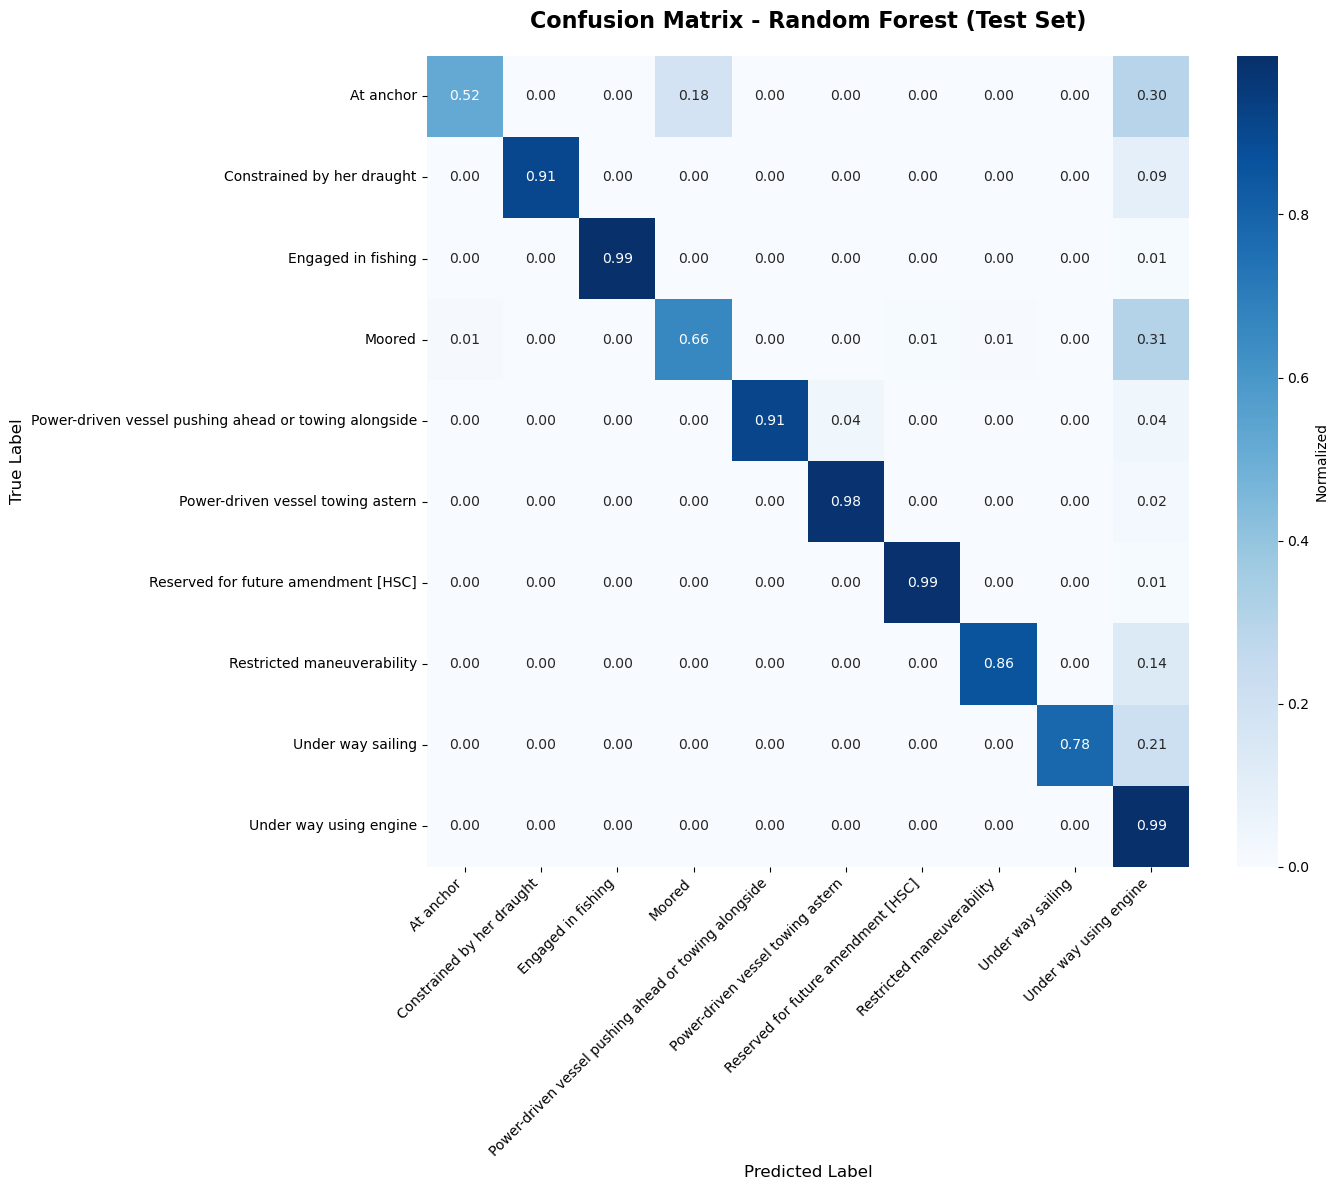


XGBoost Confusion Matrix:
Saved confusion matrix to: ../results/figures/modeling & evaluation/confusion_matrix_xgboost_test.png


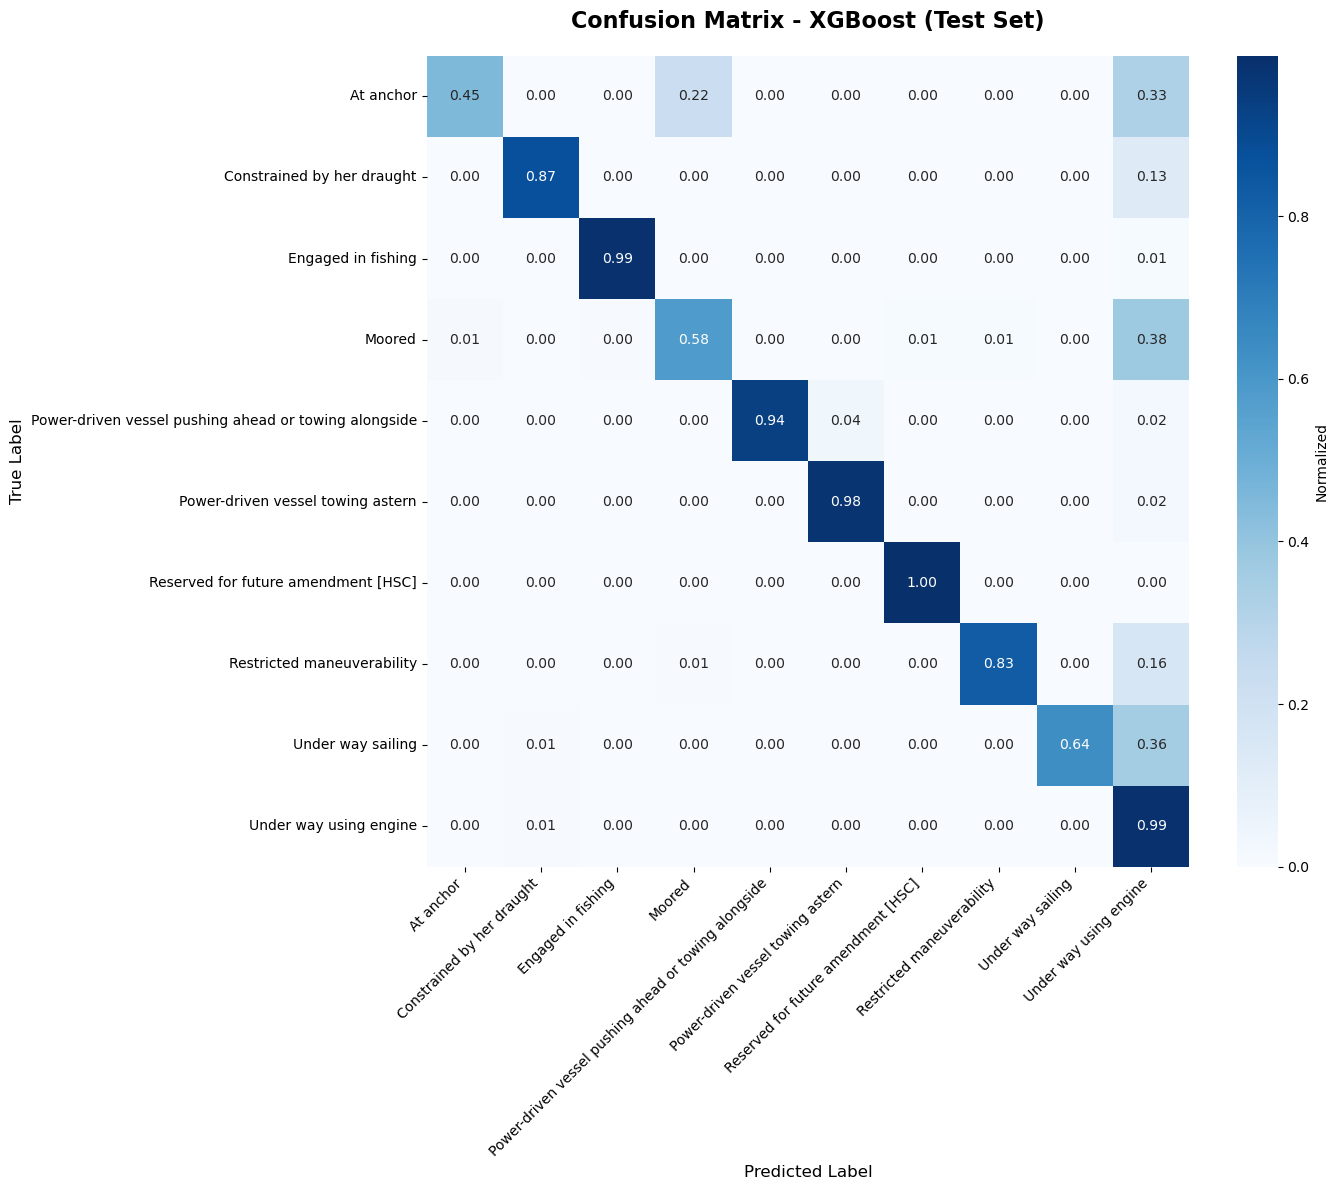


Logistic Regression Confusion Matrix:
Saved confusion matrix to: ../results/figures/modeling & evaluation/confusion_matrix_logistic_regression_test.png


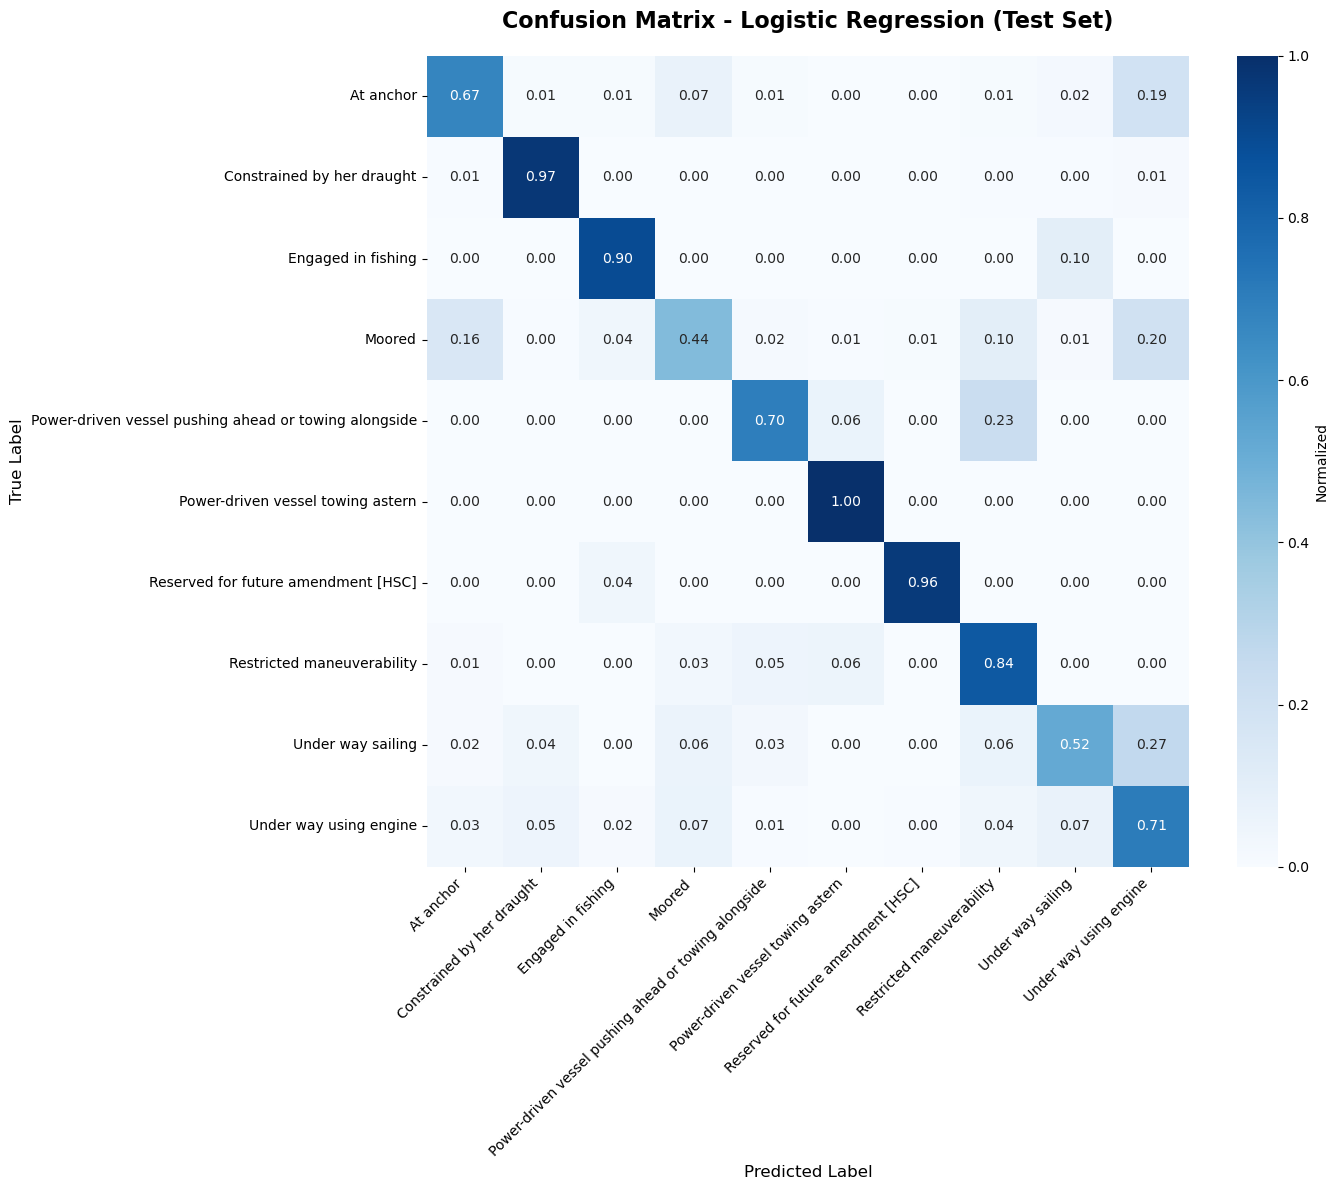

In [12]:
def plot_confusion_matrix(cm, class_names, model_name, normalize=True, save_path=None):
    """
    Plot a confusion matrix with proper formatting.
    
    Args:
        cm: Confusion matrix (numpy array)
        class_names: List of class names
        model_name: Name of the model for title
        normalize: If True, normalize the confusion matrix
        save_path: Path to save the figure (optional)
    """
    if normalize:
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_to_plot = cm_normalized
        fmt = '.2f'
        label = 'Normalized'
    else:
        cm_to_plot = cm
        fmt = 'd'
        label = 'Count'
    
    plt.figure(figsize=(14, 12))
    sns.heatmap(
        cm_to_plot,
        annot=True,
        fmt=fmt,
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        cbar_kws={'label': label}
    )
    plt.title(f'Confusion Matrix - {model_name} (Test Set)', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved confusion matrix to: {save_path}")
        _plt_original_show()
    else:
        plt.show()

class_names = sorted(y_test.unique())

print("Creating confusion matrices for all models on test set...\n")

# Random Forest 
print("Random Forest Confusion Matrix:")
plot_confusion_matrix(
    rf_test_results["confusion_matrix"],
    class_names,
    "Random Forest",
    normalize=True,
    save_path=os.path.join(FIG_DIR, "confusion_matrix_random_forest_test.png")
)

# XGBoost
print("\nXGBoost Confusion Matrix:")
plot_confusion_matrix(
    xgb_test_results["confusion_matrix"],
    class_names,
    "XGBoost",
    normalize=True,
    save_path=os.path.join(FIG_DIR, "confusion_matrix_xgboost_test.png")
)

# Logistic Regression
print("\nLogistic Regression Confusion Matrix:")
plot_confusion_matrix(
    lr_test_results["confusion_matrix"],
    class_names,
    "Logistic Regression",
    normalize=True,
    save_path=os.path.join(FIG_DIR, "confusion_matrix_logistic_regression_test.png")
)

All three models are most accurate for classes with clear and unique motion patterns, like "Engaged in fishing", "Power-driven vessel towing astern", and "Reserved for future amendment (HSC)". This shows that AIS motion features by themselves are very good at predicting these behaviors. 

Logistic Regression performs worse on more subtle classes like At anchor and Moored, which suggests linear methods struggle with complex vessel movements. 

Random Forest and XGBoost do better on these tricky classes, but still confuse Moored and At anchor, probably because both tend to have similar slow speeds and low turning rates. 

Overall, XGBoost separates almost all classes best, showing that gradient-boosted trees work very well for this type of AIS classification.